In [ ]:
########################## SCATTER DENSITY PLOT ########################
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from matplotlib import ticker
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn.linear_model import LinearRegression

def setTickFontSize(ax, size):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(size + 5)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(size)

def densityScatter( x , y,  xlim, ylim, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = False )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    ax.scatter( x, y, c=z, s = 0.5, **kwargs, cmap = 'hot' )
    ax.set_xlim(left = 0, right = xlim)
    ax.set_ylim(bottom = 0, top = ylim)
    norm = Normalize(vmin = np.min(data), vmax = np.max(data))
    cbar = plt.colorbar(cm.ScalarMappable(norm = norm, cmap = 'hot'), ax=ax)
    cbar.ax.set_ylabel('Density', fontsize = 20)
    cbar.ax.tick_params(labelsize = 17)
    return ax

def abline(ax, slope, intercept, c, linestyle, label):
    """Plot a line from slope and intercept"""
    #axes = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, linestyle = linestyle, c = c, label = label)
    return ax
    
def correlationPlotOne(fig, ax, pol, model, X, Y, i):
    X.flatten()
    Y.flatten()
    ax = densityScatter(X, Y, 400, 400 , ax = ax)
    regr = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    ax = abline(ax, regr.coef_[0][0], regr.intercept_[0], 'blue', '--', 
                "$\hat{Z} = $" + 
            f"{round(regr.intercept_[0], 2)} + " + 
            f"{round(regr.coef_[0][0], 2)}" +
            "$Z$")
    ax = abline(ax, 1, 0, 'black', '-', '$\hat{Z} = Z$')
    ax.set_xlabel("Observed " + pol + " ($\mu g/m^3$)", fontsize = 25)
    ax.set_ylabel("Estimated " + pol + " ($\mu g/m^3$)", fontsize = 25)
    ax.set_title(model, fontsize = 25)
    ax.legend(fontsize = 20, loc = 'upper left')
    setTickFontSize(ax, 20)
      
def correlationPlot(X, Y):
    Pols = ["$PM_{10}$", "$PM_{2.5}$"]
    #plt.subplots_adjust(hspace = 0.8)
    fig, ax = plt.subplots(2, 4, figsize = (35, 15), constrained_layout=True)
    for i, pol in enumerate(Pols):
        for j, model in enumerate(X[i].keys()):
            correlationPlotOne(fig, ax[i, j], pol, model, X[i][model], Y[i][model], i)
    #plt.tight_layout()
    fig.autofmt_xdate()

In [ ]:
########################## TAYLOR DIAGRAM ########################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa


class TaylorDiagram(object):
  def __init__(self, STD ,fig=None, rect=111, label='_'):
    self.STD = STD
    tr = PolarAxes.PolarTransform()
    # Correlation labels
    rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
    tlocs = np.arccos(rlocs) # Conversion to polar angles
    gl1 = gf.FixedLocator(tlocs) # Positions
    tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
    # Standard deviation axis extent
    self.smin = 0
    self.smax = 1.6 * self.STD
    gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
    if fig is None:
      fig = plt.figure()
    ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
    fig.add_subplot(ax)

    # Angle axis
    ax.axis['top'].set_axis_direction('bottom')
    ax.axis['top'].label.set_text("Correlation coefficient")
    ax.axis['top'].toggle(ticklabels=True, label=True)
    ax.axis['top'].major_ticklabels.set_axis_direction('top')
    ax.axis['top'].label.set_axis_direction('top')
    # X axis
    ax.axis['left'].set_axis_direction('bottom')
    ax.axis['left'].label.set_text("Standard deviation")
    ax.axis['left'].toggle(ticklabels=True, label=True)
    ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
    ax.axis['left'].label.set_axis_direction('bottom')
    # Y axis
    ax.axis['right'].set_axis_direction('top')
    ax.axis['right'].label.set_text("Standard deviation")
    ax.axis['right'].toggle(ticklabels=True, label=True)
    ax.axis['right'].major_ticklabels.set_axis_direction('left')
    ax.axis['right'].label.set_axis_direction('top')
    # Useless
    ax.axis['bottom'].set_visible(False)
    # Contours along standard deviations
    ax.grid()
    self._ax = ax # Graphical axes
    self.ax = ax.get_aux_axes(tr) # Polar coordinates
    # Add reference point and STD contour
    l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
    #l1 , = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
    t = np.linspace(0, (np.pi / 2.0))
    #t1 = np.linspace(0, (np.pi / 2.0))
    r = np.zeros_like(t) + self.STD
    #r1 = np.zeros_like(t) + self.STD
    self.ax.plot(t, r, 'k--', label='_')
    # Collect sample points for latter use (e.g. legend)
    self.samplePoints = [l]
    #self.samplePoints = [l1]
    
  def add_sample(self,STD,r,*args,**kwargs):
    l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
    self.samplePoints.append(l)
    return l

  #def add_sample(self,STD,r1,*args,**kwargs):
    #l1,= self.ax.plot(np.arccos(r1), STD, *args, **kwargs) # (theta, radius)
    #self.samplePoints.append(l1)
    #return l1

  def add_contours(self,levels=5,**kwargs):
    rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
    RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
    contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
    return contours

def srl(obsSTD, s, s1, r, r1, l, l1, fname):
  fig=plt.figure(figsize=(8,8))
  dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='ref')
  plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)
  srlc = zip(s, r, l)
  srlc1 = zip(s1, r1, l1)
   
  for i in srlc:
    dia.add_sample(i[0], i[1], label=i[2], marker='o',mec = 'red', mfc = 'none', mew=1.6)
  for i in srlc1:
    dia.add_sample(i[0], i[1], label=i[2], marker='^', mec = 'blue', mfc = 'none', mew=1.6)
  spl = [p.get_label() for p in dia.samplePoints]
  fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.7,0.3])
  plt.show()


def plotTaylor(obsSTD, s,  r, l, pol):
  fig = plt.figure(figsize = (8,8))
  dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')
  plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)
  srlc = zip(s, r, l)
   
  for i in srlc:
    dia.add_sample(i[0], i[1], label=i[2],marker='o')
    
  spl = [p.get_label() for p in dia.samplePoints]
  #fig.legend()
  fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.8,0.8])
  fig.suptitle(pol + " Taylor diagram")
  #fig.legend(dia.samplePoints, spl, loc=[0.8,0.8])
  plt.show()
  

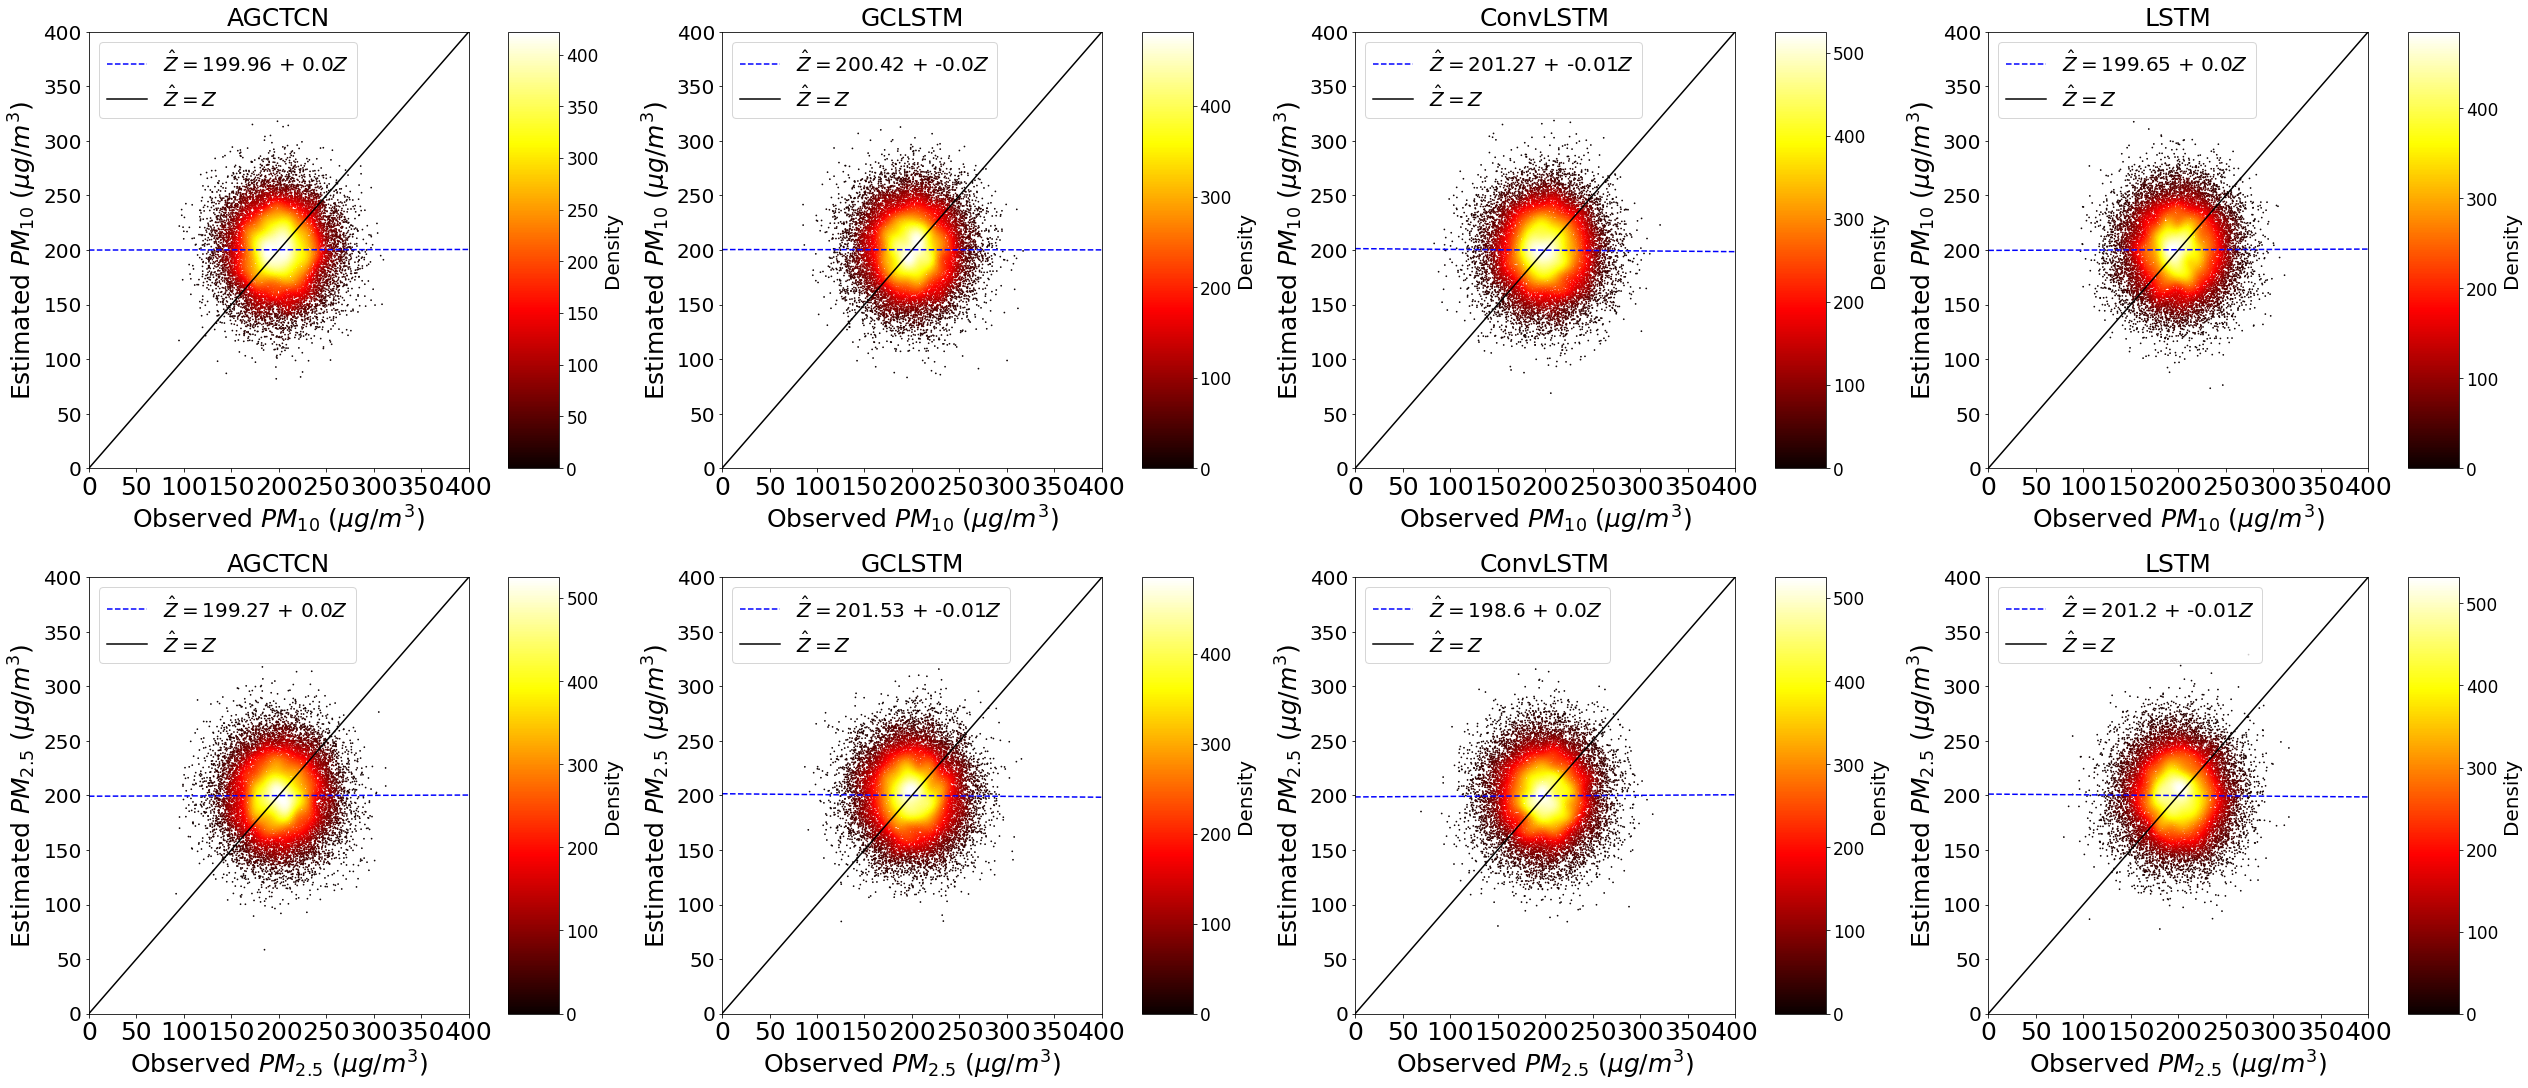

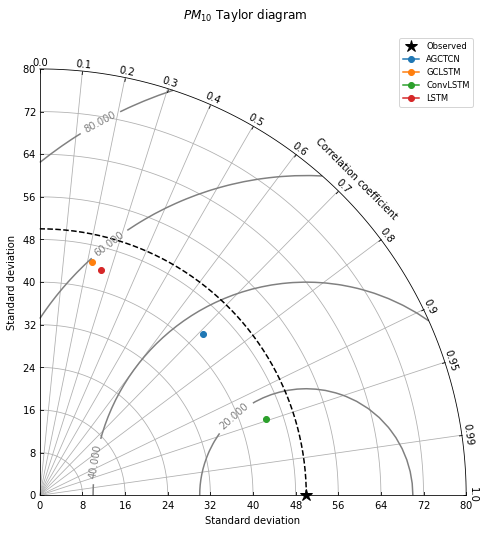

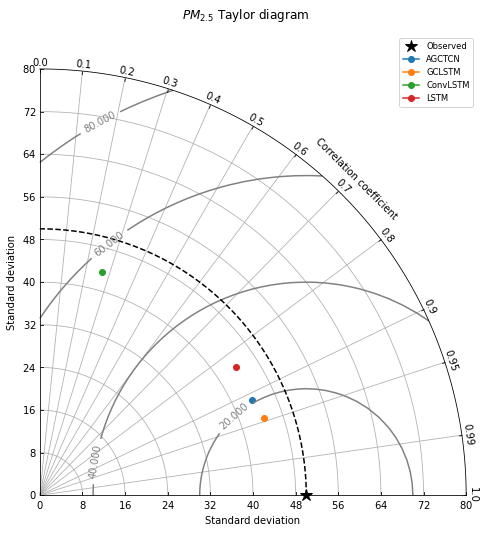

In [ ]:
# Test code
X = [dict(), dict()]
Y = [dict(), dict()]
keys = ["AGCTCN", "GCLSTM", "ConvLSTM", "LSTM"]
for i in range(len(X)):
  for key in keys:
    X[i][key] = 200 + 30 * np.random.randn(20000)
    Y[i][key] = 200 + 30 * np.random.randn(20000)
correlationPlot(X, Y)
pollutants = ["$PM_{10}$", "$PM_{2.5}$"]
for i in range(len(pollutants)):
  observedSTD = 50
  modelwiseSTD = 43 + 2 * np.random.rand(4)
  modelwiseCORR = np.random.rand(4)
  plotTaylor(observedSTD, modelwiseSTD, modelwiseCORR, keys, pollutants[i])